In [1]:
from cartpole.simulator.pytorch.config import SystemConfiguration
from cartpole.simulator.pytorch.system import CartPoleSystem
from cartpole.simulator.pytorch.state import State

import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## About the simulation

Our simulation's state is represented via 4 numbers:
- $x$ - cart position on the rail (default value is 0, right is positive).
- $\theta$ - pole angle in radians. The default value is 0, when the pole is hanging down. Always belongs to $[0, 2\pi)$
- $\dot{x}$ - cart velocity.
- $\dot{\theta}$ - pole angular velocity (in radians, positive if CCW).

## Pendulum (simple case)

Let us consider a system with no input first.
In other words, just a simple pendulum.

In [2]:
system = CartPoleSystem()
system.reset_to_state(
    config=SystemConfiguration(),
    state=State(
        cart_position=0,
        pole_angle=1.23,
        cart_velocity=0,
        angular_velocity=0,
    ),
)
system.set_target(0.0)

In [3]:
%timeit
SECONDS_TO_SIMULATE = 5
INPUT_DELTA = 0.03

SIM_STEPS = int(SECONDS_TO_SIMULATE / INPUT_DELTA)

history = np.empty(shape=(SIM_STEPS, 6))


for i in range(SIM_STEPS):
    state = system.get_state().as_tensor()

    history[i, 0] = system.timestamp()
    history[i, 1:5] = state
    history[i, 5] = 0.0

    system.advance(delta=INPUT_DELTA)

At this point, we have simulated 5 seconds of pendulum swinging.
Let us use Pandas DataFrames to explore the data we got from the simulation.

In [4]:
def history_to_pandas(history: npt.NDArray) -> pd.DataFrame:
    """
    Converts history array to pandas DataFrame

    Args:
        history (npt.NDArray): Nx6 array of floats

    Returns:
        pd.DataFrame: Same array but dataframe
    """
    COLUMNS = [
        "timestamp",
        "cart_position",
        "pole_angle",
        "cart_velocity",
        "pole_angular_velocity",
        "cart_acceleration",
    ]
    return pd.DataFrame(
        {column_name: history[:, ind] for ind, column_name in enumerate(COLUMNS)}
    )

And let us also define a function to calculate energies of our system for each point of time

In [5]:
def add_energies(history: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates energies and returns a copy of dataframe with 4 extra columns:
    - cart kinetic energy
    - pole kinetic energy
    - pole potential energy
    - total energy

    Args:
        history (pd.DataFrame)

    Returns:
        pd.DataFrame
    """
    m_cart = system._config.parameters.cart_mass or 0.2
    m_pole = system._config.parameters.pole_mass
    l = system._config.parameters.pole_length
    g = system._config.parameters.gravity

    x_dot = history["cart_velocity"]
    theta = history["pole_angle"]
    theta_dot = history["pole_angular_velocity"]

    kin_cart = m_cart * (x_dot**2) / 2  # type: ignore
    pot_pole = m_pole * g * l / 2 * (1 - np.cos(theta))

    kin_pole = (m_pole/ 2) * (
        x_dot**2
        + ((l**2) * (theta_dot**2)) / 3
        + (l * x_dot * theta_dot * np.cos(theta))
    )

    energies = {
        "kinetic_cart": kin_cart,
        "kinetic_pole": kin_pole,
        "potential_pole": pot_pole,
        "total_energy": kin_cart + kin_pole + pot_pole,
    }

    return history.assign(**energies)

In [6]:
history = history_to_pandas(history)
history = add_energies(history)
history.head()

,timestamp,cart_position,pole_angle,cart_velocity,angular_velocity,acceleration,kinetic_cart,kinetic_pole,potential_pole,total_energy
0,0.00,0.0,1.230000,0.0,0.000000,0.0,0.0,0.000000,0.115566,0.115566
1,0.03,0.0,1.209229,0.0,-1.382986,0.0,0.0,0.003385,0.112180,0.115566
2,0.06,0.0,1.147240,0.0,-2.743828,0.0,0.0,0.013326,0.102240,0.115566
3,0.09,0.0,1.045102,0.0,-4.053903,0.0,0.0,0.029088,0.086477,0.115566
4,0.12,0.0,0.904910,0.0,-5.273014,0.0,0.0,0.049214,0.066351,0.115566


Now lets plot some graphs

<AxesSubplot: xlabel='timestamp', ylabel='total_energy'>

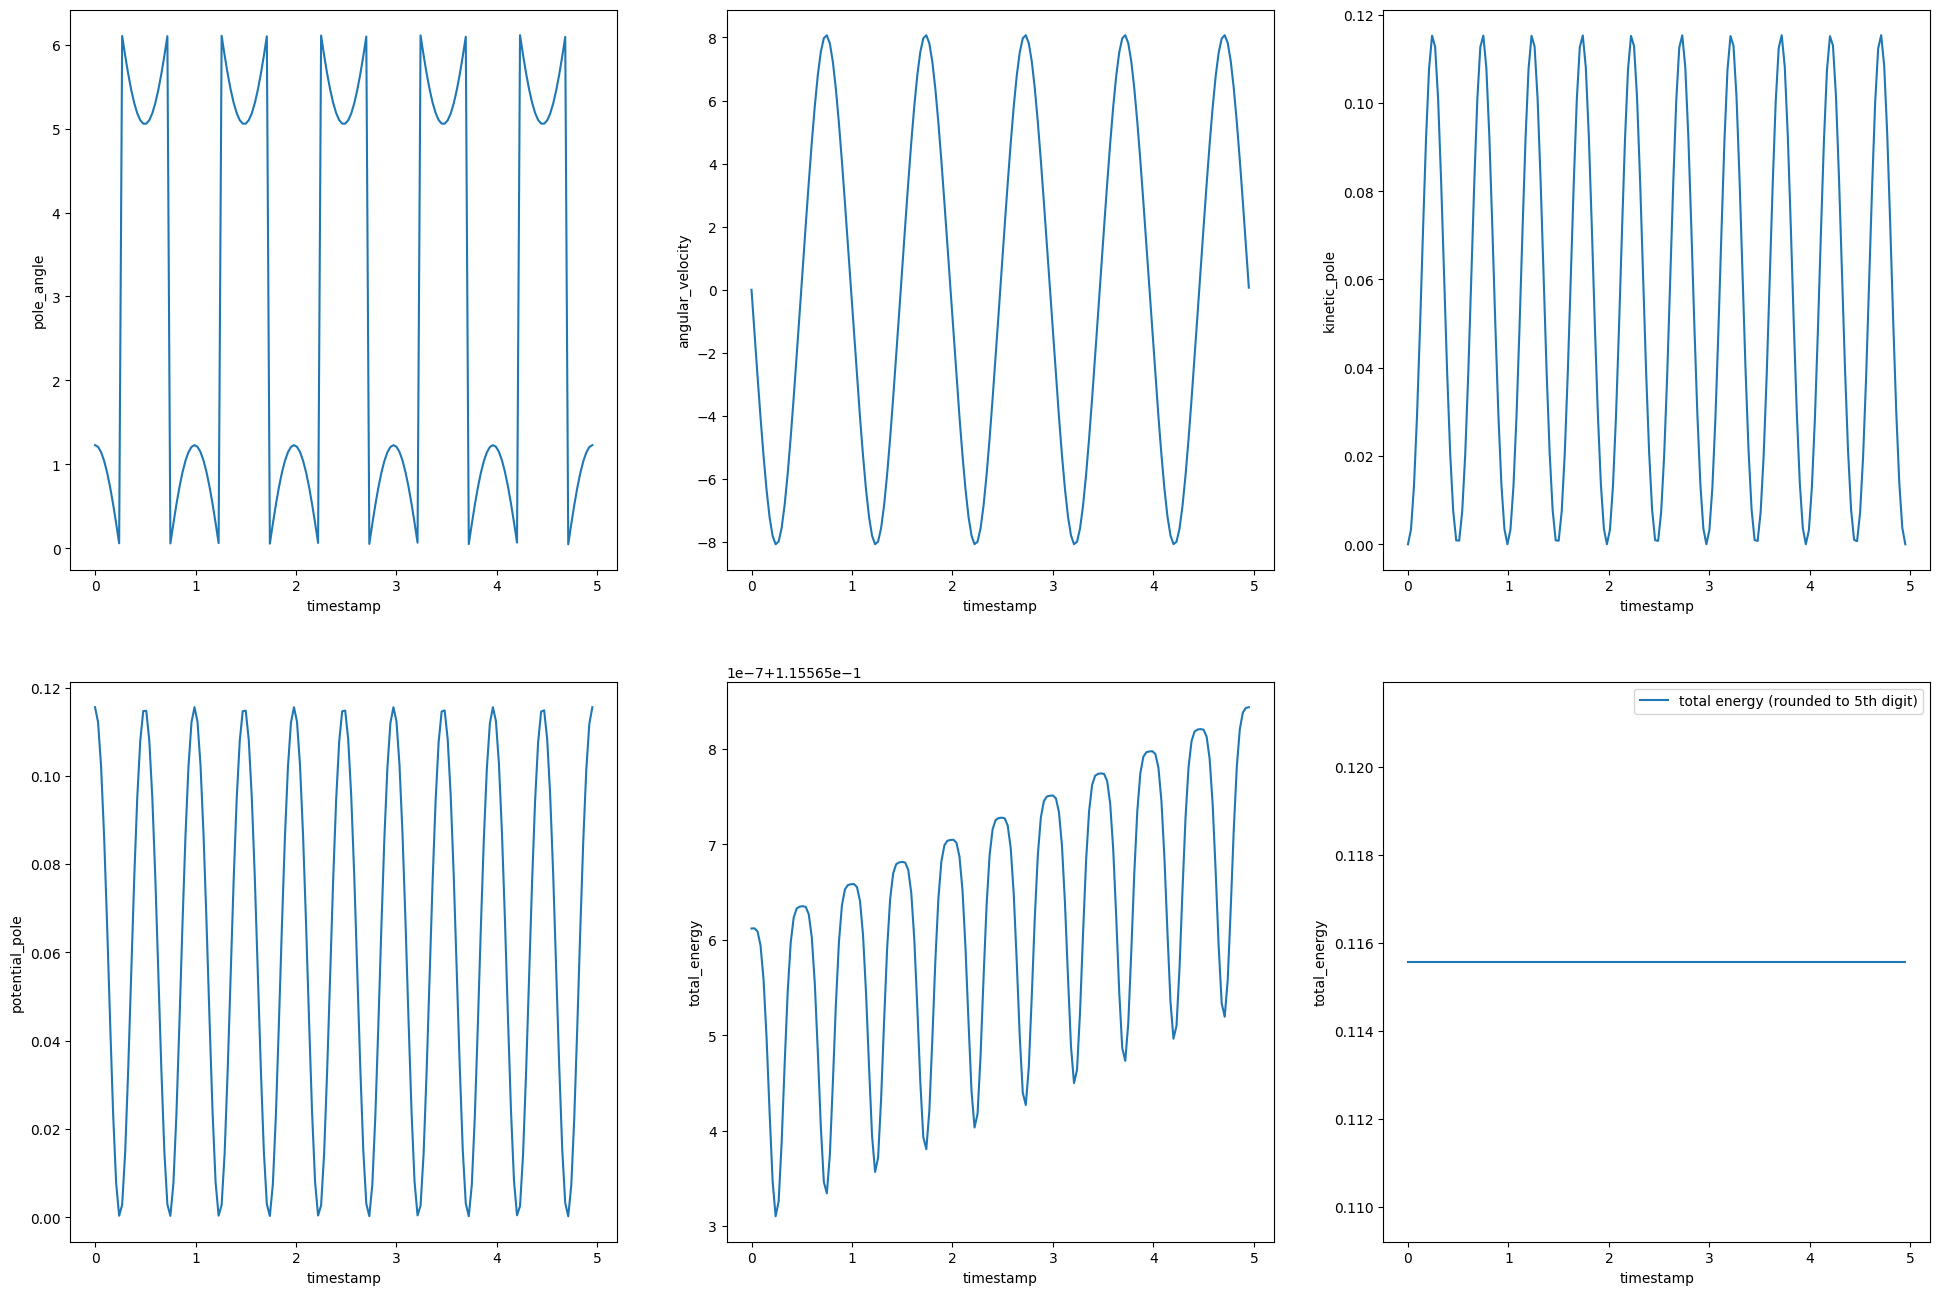

In [7]:
from math import ceil


PLOT_COLUMNS = [
    "pole_angle",
    "pole_angular_velocity",
    "kinetic_pole",
    "potential_pole",
    "total_energy",
]

nrows = round(np.sqrt(len(PLOT_COLUMNS)))
ncols = ceil(len(PLOT_COLUMNS) / nrows)


fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(8 * ncols, 8 * nrows),
)


for i, column in enumerate(PLOT_COLUMNS):
    cur_ax = ax[i // ncols][i % ncols]
    sns.lineplot(
        data=history,
        x="timestamp",
        y=column,
        ax=cur_ax,
    )


sns.lineplot(
    data=history,
    x="timestamp",
    y=np.round(history["total_energy"], 5),
    ax=ax[1, 2],
    label="total energy (rounded to 5th digit)",
)

On the second graph from the second row one migth see that `total_energy` seems to be increasing over time.
Please, note the scale of the graph - the difference is not that dramatic.
We included the last graph to show that: it contains `total_energy`, but rounded to 5-th digit after the dot.
One might see that the total energy is indeed constant.

## CartPole (more complex case)

This time we will make use of controlling the system.
To be precise, we will introduce cart acceleration.

In [8]:
system = CartPoleSystem()
system.reset_to_state(
    config=SystemConfiguration(),
    state=State.home(),
)

In [9]:
%timeit
SECONDS_TO_SIMULATE = 8
INPUT_DELTA = 0.03

SIM_STEPS = int(SECONDS_TO_SIMULATE / INPUT_DELTA)

history = np.empty(shape=(SIM_STEPS, 6))

for i in range(SIM_STEPS):
    # This time we calculate the acceleration of the cart using some weird formula
    k = int((i % 100) < 50)
    acc = (-1)**k * i / SIM_STEPS
    system.set_target(acc)

    state = system.get_state().as_tensor()

    history[i, 0] = system.timestamp()
    history[i, 1:5] = state
    history[i, 5] = acc

    system.advance(delta=INPUT_DELTA)

Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 2. Simulation is stopped
Error occurred: 

Note that we specifically designed our input function the way that it violates config restrictions.
In this case, the carts absolute position was greater than the one specified in the config limits (0.25m).
Therefore, the simulation stopped.

In [10]:
history = history_to_pandas(history)
history = add_energies(history)
history.head()

,timestamp,cart_position,pole_angle,cart_velocity,angular_velocity,acceleration,kinetic_cart,kinetic_pole,potential_pole,total_energy
0,0.00,0.000000e+00,0.000000,0.00000,0.000000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.03,0.000000e+00,0.000000,0.00000,0.000000,-0.002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.06,-9.000000e-07,0.000004,-0.00006,0.000298,-0.004,3.600000e-10,5.310856e-11,1.744704e-12,4.148533e-10
3,0.09,-4.500000e-06,0.000022,-0.00018,0.000880,-0.006,3.240000e-09,4.785864e-10,4.285394e-11,3.761440e-09
4,0.12,-1.260000e-05,0.000061,-0.00036,0.001722,-0.008,1.296000e-08,1.922394e-09,3.271844e-10,1.520958e-08


<AxesSubplot: xlabel='timestamp', ylabel='pole_angle'>

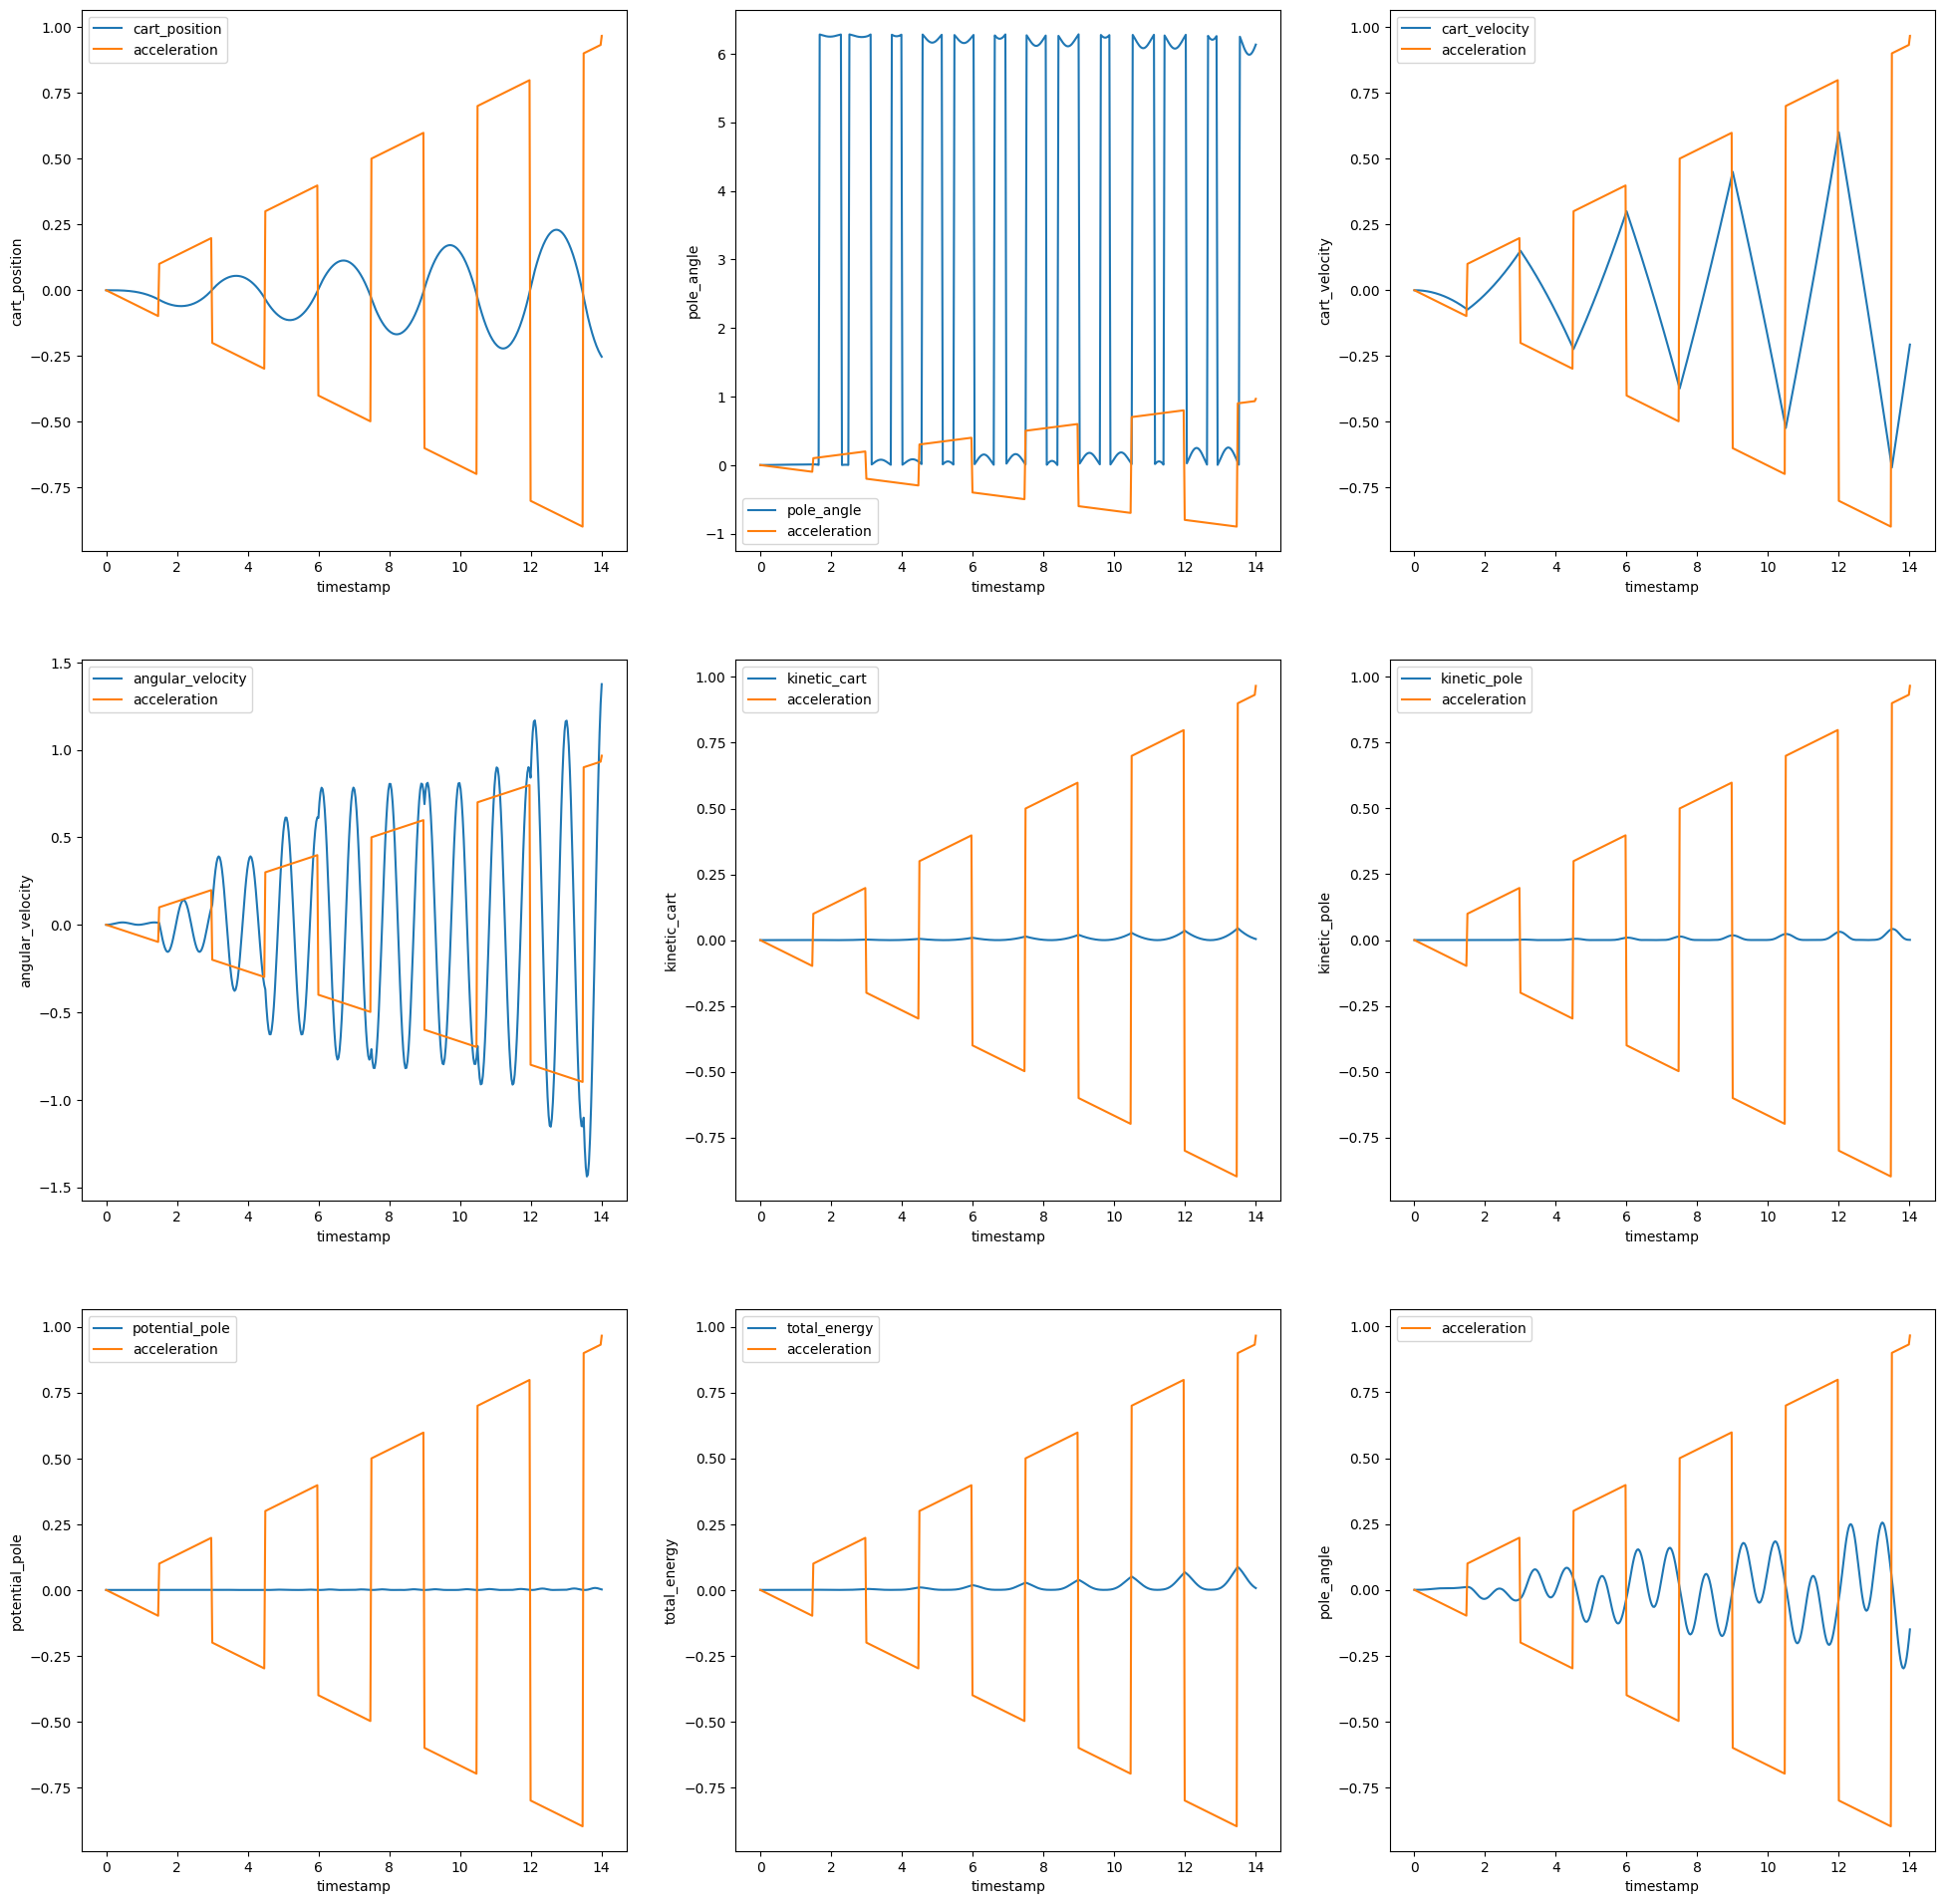

In [11]:
PLOT_COLUMNS = [
    "cart_position",
    "pole_angle",
    "cart_velocity",
    "pole_angular_velocity",
    "kinetic_cart",
    "kinetic_pole",
    "potential_pole",
    "total_energy",
]

nrows = round(np.sqrt(len(PLOT_COLUMNS)))
ncols = ceil(len(PLOT_COLUMNS) / nrows)

fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(8 * ncols, 8 * nrows),
)

for i, column in enumerate(PLOT_COLUMNS):
    cur_ax = ax[i // ncols][i % ncols]
    sns.lineplot(
        data=history,
        x="timestamp",
        y=column,
        ax=cur_ax,
        label=column,
    )
    sns.lineplot(
        data=history,
        x="timestamp",
        y="cart_acceleration",
        ax=cur_ax,
        label="acceleration",
    )

angles_fix_mask = history["pole_angle"] > 5.5
fixed_angles = history["pole_angle"].copy(True)
fixed_angles[angles_fix_mask] -= 2 * np.pi
sns.lineplot(
    data=history,
    x="timestamp",
    y=fixed_angles,
    ax=ax[2][2],
)
sns.lineplot(
    data=history,
    x="timestamp",
    y="cart_acceleration",
    ax=ax[2][2],
    label="cart_acceleration",
)

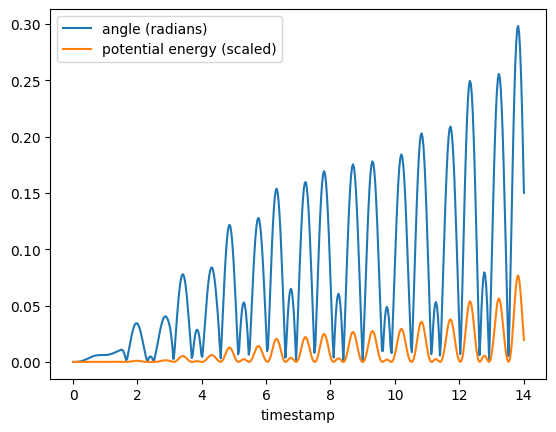

In [12]:
g = sns.lineplot(
    data=history,
    x="timestamp",
    y=np.abs(fixed_angles),
    label="angle (radians)",
)
g.set_ylabel("")
sns.lineplot(
    data=history,
    x="timestamp",
    y=history["potential_pole"] * 10,
    label="potential energy (scaled)",
)
g.set_ylabel("");

## Benchmark

Now we want to compare how stateful simulator performs compared to stateless one.
To be precise, we will see how much slower it is to run 1 simulation vs 20 vs 50 vs 1000.
We will simulate 15 seconds of system motion.

In [13]:
from time import time


N_REPEATS = 30

### One system

In [14]:
system = CartPoleSystem()
system.reset_to_state(
    config=SystemConfiguration(),
    state=State(
        cart_position=0,
        pole_angle=1.23,
        cart_velocity=0,
        angular_velocity=0,
    ),
)
system.set_target(0.0)

In [15]:
SECONDS_TO_SIMULATE = 15
INPUT_DELTA = 0.03

SIM_STEPS = int(SECONDS_TO_SIMULATE / INPUT_DELTA)

start_time = time()

for _ in range(N_REPEATS):
    for i in range(SIM_STEPS):
        system.advance(delta=INPUT_DELTA)
    
end_time = time()
print("Average time:", round((end_time - start_time) / N_REPEATS, 5))

### 20 Systems

In [ ]:
from simulator_v2.cartpole_torch.config import SystemConfiguration
from simulator_v2.cartpole_torch.system import CartPoleMultiSystem
from simulator_v2.cartpole_torch.learning_context import MultiSystemLearningContext
from simulator_v2.cartpole_torch.state import MultiSystemState
from simulator_v2.cartpole_torch.discreditizer import Discreditizer
import torch

In [ ]:
system = CartPoleMultiSystem()
config = SystemConfiguration()
context = MultiSystemLearningContext(
    states_cost_fn=None,
    inputs_cost_fn=None,
    config=config,
    batch_state=None,
    discreditizer=Discreditizer(config),
)

In [ ]:
SIM_STEPS = SECONDS_TO_SIMULATE * config.discretization.simulation_step_n
context.update_batch(batch_size=20)
inputs = torch.zeros(20)

start_time = time()

for _ in range(N_REPEATS*SIM_STEPS):
    # for _ in range(SIM_STEPS):
    context.update_batch(batch_size=20)
    system.eval_transitions(context, inputs)

end_time = time()

print("Average time:", round((end_time - start_time) / N_REPEATS, 5))

### 50 systems

In [ ]:
SIM_STEPS = SECONDS_TO_SIMULATE * config.discretization.simulation_step_n
context.update_batch(batch_size=50)
inputs = torch.zeros(50)

start_time = time()

for _ in range(N_REPEATS):
    for _ in range(SIM_STEPS):
        context.update_batch(batch_size=50)
        system.eval_transitions(context, inputs)

end_time = time()

print("Average time:", round((end_time - start_time) / N_REPEATS, 5))

### 1000 systems

In [ ]:
SIM_STEPS = SECONDS_TO_SIMULATE * config.discretization.simulation_step_n
context.update_batch(batch_size=1000)
inputs = torch.zeros(1000)

start_time = time()

for _ in range(N_REPEATS):
    for _ in range(SIM_STEPS):
        context.update_batch(batch_size=1000)
        system.eval_transitions(context, inputs)

end_time = time()

print("Average time:", round((end_time - start_time) / N_REPEATS, 5))